<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a>
<img border="0" src="https://www.ip-paris.fr/wp-content/uploads/2019/09/logo-IP-Paris-sur-fond-blanc.jpg" width="90%"> </td>
     <td style="background-color:transparent;">
<img border="0" src="https://upload.wikimedia.org/wikipedia/commons/0/05/POLYTECHNIQUE-IP_PARIS.png" width="25%"> </td>
  </tr>
</table> 
</div>

<center><h1>Auto-Industry stock prediction challenge</h1></center>
<br/>
<center><b>ABBOUDI Mohammed Amine, ABOU EL QASSIME Mehdi, AL MOSLLI Imad, ASADULLAH Adnane, ENNADIR Sofiane and MAJDOUBI Ahmed Amine.</b></center>

## Table of Contents

0. [Introduction](#Introduction)
1. [Data](#Data)
3. [Data treatment](#Data-treatment)
3. [Data Visualization](#Data-Visualization)
4. [Score metric](#Score-metric)
5. [Predictions](#Predictions)
6. [Submitting to RAMP studio](#Submitting-to-[ramp.studio](http://ramp.studio))

# Introduction

The objective of this challenge is to predict the impact of a product recall on a company's stock price, more precisely we study said impact on the biggest automobile groups. A product recall is a procedure launched by a company to get back a product sold to consumers because it is suscpected to have a defect. 

The correlation between a product recall and a company's share value has been demonstrated by empirical studies (see the article <ins>Automotive Recalls and Informational Efficiency</ins> fom *Hoffer, Pruitt & Reillt* in 1987 on the Financial Review). Thus, the impact will be measured through the company's stock price depreciation.

We will use data coming from 3 sources : 

* The Vehicle Safety Branch Recalls Database from UK government to get data on automobile recalls (https://data.gov.uk/dataset/18c00cf3-3bb2-4930-b30d-78113113aaa7/vehicle-safety-branch-recalls-database)

* Yahoo! Finance to get stock price data (https://fr.finance.yahoo.com)

* Finally, we will use data from ADEME (French environment agency) that give will give us some information about the vehicles (https://www.data.gouv.fr/fr/datasets/emissions-de-co2-et-de-polluants-des-vehicules-commercialises-en-france/#_)



# Data

## UK Recalls data

This dataset is an inventory of all the automobile recalls since 1992. We remind that a recall is legally mandatory. Each row represents a recall. We have information about the date of the recall, the model, the brand the nature of the defect and the number of vehicles affected:

* `Launch Date` - Date when the recall started
* `Recalls Number` Identification number
* `Make` Brand commercializing the vehicle
* `Recalls Model Information` - model of the vehicle
* `Concern` - Category of the defect causing the recall
* `Defect` - More details about the recall
* `Remedy` - Action needed to settle the problem
* `Vehicle Numbers` - Number of vehicles affected
* `Manufacturer Ref` - identifier of the manufacturer
* `Build Start` - Date of beginning of production of the vehicle
* `Build End` - Date of end of production of the vehicle


##  ADEME Vehicles data

This database gathers all the datasets published since 2001 in the website https://www.data.gouv.fr/fr/. The data comes from an organism in charge of vehicles homologation in France and thus contains all the vehicles commercialised in France. It is the case of most of the vehicles in the UK (although not all). It contains information about the vehicle consumption, power and category:

* `lib_mrq` - Marque de la voiture
* `lib_mod` - Modèle
* `dscom` - Détails sur le modèle
* `cnit` - Immatriculation
* `puiss_admin_98` - Puissance fiscale
* `puiss_max` - Puissance du véhicule (en chevaux)
* `typ_boite_nb_rapp` - Nombre de rapport de vitesse
* `conso_urb` - Consommation de carburant en ville (l/100 km)
* `conso_exurb` - Consommation hors ville
* `conso_mixte` - Consommation moyenne
* `co2` - Rejet de CO2 du véhicule (g/km)



##  Yahoo! Finance stock data

This website gives information on all the publicly traded companies' stock prices. We retrieve the information we need using pandas datareader. The data is first organized as follows : The dates along the rows and the stocks along the columns. We then restructure the dataset to merge with the other ones : we have everything in rows with only three columns: the date, the group and the stock price impact). See the notebook stock_price.ipynb for more details on how the target variable is percieved and computed.

The datasets provided are, relatively speaking, quite small in terms of observations but also rich in terms of content. This is primarily an exercise in finding ways to maximize the predictive power of a quantitavely limited yet qualitatively rich dataset.



# Data treatment
In this section, we lay out how the datasets are processed after ingestion. We then carry out a merging technique to minimize the number of lost rows during the joing of the CO2 and the recalls datasets. We choose to merge because the existing data is mostly in the form of quite unstructured text, full of technical jargon.
We expect that this area is further explored during the participants' attempts.

In [1]:
%matplotlib inline
import imp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from problem import get_train_data

data_repo = 'data/'
df_recall, y_array = get_train_data()
df_co2 = pd.read_csv(data_repo+'data_co2.csv', low_memory=False)
df_groupe_marque = pd.read_excel(data_repo+'voiture_groupe_marque.xlsx')

### Function to clean df_co2 dataset

First of all, we will do some basic cleaning to the recall and co2 columns:

Replace ',' with '.' in numerical columns
Replace '-' with a space on brand names, and strip any excess white space

In [3]:
df_co2['Marque'] = df_co2['Marque'].apply(lambda x : x.strip())
df_co2['Marque'] = df_co2['Marque'].apply(lambda x : x.replace('-', ' '))

for col in ['Consommation mixte (l/100km)', 'Consommation urbaine (l/100km)', 'Puissance maximale (kW)']:
    df_co2[col] = df_co2[col].apply(
        lambda x: str(x).replace(',','.')).astype(float)

for col in ['Consommation extra-urbaine (l/100km)', 'Boîte de vitesse']:
    df_co2[col] = df_co2[col].apply(
        lambda x: str(x).replace(',','.'))
    df_co2[col] = df_co2[col].apply(
        lambda x: str(x).strip())

We observe that 'Consommation extra-urbaine' is not entirely numerical, and the unique values of the non numerical lines are those of 'Boîte de vitesse' column. Let's investigate this problem.

In [4]:
non_numerical = list(['A6', 'A 6', 'V .', 'M 0', 'A5', 'N 0', 'M 5', 'V 0', 'D 5', 'M', 'N 1',
                     'V 1', 'M 7', 'S 6', 'A 7', 'A 1', '5', 'M 1', 'D 7', 'A 0', 'M 6', 'A 3',
                     'N', 'A 5', 'A 8', 'D 6', '6', 'A 4', 'M5', 'M6', 'A4', 'A 9'])

print('Number of non numerical values in Consommation extra-urbaine: ', len(
    df_co2[df_co2['Consommation extra-urbaine (l/100km)'].isin(non_numerical)]))

print('Number of numerical values in Boîte de vitesse: ', len(
    df_co2[~(df_co2['Boîte de vitesse'].isin(non_numerical))]))

print('Intersection between these two lists of rows: ', len(df_co2[~(df_co2['Boîte de vitesse'].isin(non_numerical))][
    df_co2['Consommation extra-urbaine (l/100km)'].isin(non_numerical)]))

Number of non numerical values in Consommation extra-urbaine:  7364
Number of numerical values in Boîte de vitesse:  6599
Intersection between these two lists of rows:  6599


So we observe that all the lines that have numerical values in 'Boîte de vitesse' column, have non numerical values in 'Consommation extra-urbaine (l/100km)' column. Let's switch the two columns values for these lines.

In [5]:
for index, row in tqdm(df_co2[~(df_co2['Boîte de vitesse'].isin(non_numerical))].iterrows()):
    switch_value = row['Boîte de vitesse']
    df_co2.loc[index,'Boîte de vitesse'] = row['Consommation extra-urbaine (l/100km)']
    df_co2.loc[index,'Consommation extra-urbaine (l/100km)'] = switch_value

6599it [05:10, 21.24it/s]


In [6]:
print('Number of non numerical values in Consommation extra-urbaine: ', len(
    df_co2[df_co2['Consommation extra-urbaine (l/100km)'].isin(non_numerical)]))

print('Number of numerical values in Boîte de vitesse: ', len(
    df_co2[~(df_co2['Boîte de vitesse'].isin(non_numerical))]))

print('Intersection between these two lists of rows: ', len(df_co2[~(df_co2['Boîte de vitesse'].isin(non_numerical))][
    df_co2['Consommation extra-urbaine (l/100km)'].isin(non_numerical)]))

Number of non numerical values in Consommation extra-urbaine:  765
Number of numerical values in Boîte de vitesse:  0
Intersection between these two lists of rows:  0


Let's remove the 765 lines with non numerical 'Consommation extra-urbaine (l/100km)' values, and convert the column to float.

In [7]:
df_co2 = df_co2[~df_co2['Consommation extra-urbaine (l/100km)'].isin(non_numerical)]
df_co2['Consommation extra-urbaine (l/100km)'] = df_co2['Consommation extra-urbaine (l/100km)'].astype(float)
df_co2.drop(['Unnamed: 0', 'CNIT'], axis=1, inplace=True)
df_co2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276695 entries, 0 to 277459
Data columns (total 9 columns):
Boîte de vitesse                        276695 non-null object
Marque                                  276695 non-null object
Consommation mixte (l/100km)            276487 non-null float64
Consommation urbaine (l/100km)          270055 non-null float64
Modèle dossier                          276695 non-null object
Annee                                   276695 non-null int64
CO2 (g/km)                              276487 non-null float64
Consommation extra-urbaine (l/100km)    276488 non-null float64
Puissance maximale (kW)                 276641 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 21.1+ MB


The following is a dictionnary that will serve us to map the tagnames of relevent automotive groups unto a more mainstream tagname, used in the recalls dataset.

In [47]:
map_dict = {'VOLKSWAGEN': 'VW',
        'VOLVO': 'VOLVO CAR', # 'VOLVO BUS', 'VOLVO TRUCK'
        'MG': 'MG MOTOR',     # 'MG ROVER'
        'CHEVROLET': 'CHEVROLET UK', # 'CHEVROLET USA'
        'LEXUS': 'TOYOTA',
        'QUATTRO': 'AUDI',
        'MERCEDES AMG': 'MERCEDES BENZ', # 'MERCEDES BENZ CARS UK LTD', 'MERCEDES BENZ VANS UK LTD', 'MERCEDES BENZ BUS', 'MERCEDES BENZ TRUCKS UK LTD'
        'LTI VEHICLES': 'LTI',
        'DANGEL': 'DANGEL',
        'THE LONDON TAXI COMPANY': 'LTI',
        'RENAULT TECH': 'RENAULT', # 'RENAULT TRUCKS UK LTD', 'RENAULTTRUCKS UK LTD', 'RENAULT VI', 'RENAULT AGRICULTURE'
        'JAGUAR LAND ROVER LIMITED': 'JAGUAR',
        'MERCEDES': 'MERCEDES BENZ', # 'MERCEDES BENZ CARS UK LTD', 'MERCEDES BENZ VANS UK LTD', 'MERCEDES BENZ BUS', 'MERCEDES BENZ TRUCKS UK LTD'
        'BMW I': 'BMW', # 'BMW MOTORCYCLES', 'BMW MOTORRAD'
        'FORD CNG TECHNIK': 'FORD',
       }

not_found = ['SMART','OPEL','DAIMLER','HOMMELL','CARBODIES','LADA VAZ',
             'LADA','MAYBACH','PGO','Mia','DIJEAU CARROSSIER']

In [9]:
df_co2.Marque = df_co2.Marque.replace(map_dict)
df_co2.Marque = df_co2.Marque.str.lower()

marque_found = []
marque_not_found = []
for a in df_co2.Marque.unique():
    if a in df_recall.Make.unique():
        marque_found.append(a)
    else:
        marque_not_found.append(a)
print(len(marque_found), 'marques trouvées')
print(marque_found)
print('')
print(len(marque_not_found), 'marques non trouvées:')
print(marque_not_found)

35 marques trouvées
['peugeot', 'renault', 'audi', 'seat', 'mercedes benz', 'fiat', 'skoda', 'nissan', 'ford', 'mazda', 'citroen', 'volvo car', 'mitsubishi', 'bmw', 'alfa romeo', 'toyota', 'hyundai', 'suzuki', 'land rover', 'kia', 'jeep', 'cadillac', 'daihatsu', 'ferrari', 'honda', 'jaguar', 'maserati', 'mini', 'porsche', 'rolls royce', 'dacia', 'dodge', 'lamborghini', 'infiniti', 'tesla']

31 marques non trouvées:
['vw', 'smart', 'opel', 'mg motor', 'rover', 'lancia', 'saab', 'chrysler', 'carbodies', 'daewoo', 'ssangyong', 'isuzu', 'aston martin', 'bentley', 'chevrolet uk', 'daimler', 'hommell', 'lada vaz', 'lti', 'maybach', 'morgan', 'subaru', 'tvr', 'iveco', 'pgo', 'lada', 'hummer', 'dangel', 'dijeau carrossier', 'mia', 'lotus']


In [10]:
modele_found = []
modele_not_found = []

for a in df_co2['Modèle dossier'].unique():
    if a in df_recall.Model.unique():
        modele_found.append(a)
    else:
        modele_not_found.append(a)
print(len(modele_found), 'modèles trouvés')
print('')
print(len(modele_not_found), 'modèles non trouvés')

209 modèles trouvés

14570 modèles non trouvés


In [11]:
df_co2_num = df_co2.groupby(['Marque','Modèle dossier', 'Annee']).mean().reset_index()

df_co2_non_num = df_co2.groupby(['Marque','Modèle dossier', 'Annee'])['Boîte de vitesse'
                                                                ].agg(pd.Series.mode).reset_index()
print('Before Merge: ', len(df_co2))
df_co2 = df_co2_num.merge(df_co2_non_num, on=['Marque','Modèle dossier', 'Annee'])
print('After Merge: ', len(df_co2))

Before Merge:  276695
After Merge:  26163


Exploring and cleaning df_recall

In [12]:
df_recall['Make'] = df_recall['Make'].apply(lambda x : x.strip())
df_recall['Make'] = df_recall['Make'].apply(lambda x : x.replace('-', ' '))
df_groupe_marque['Marques'] = df_groupe_marque['Marques'].str.upper()

df_recall['Launch Date']= pd.to_datetime(df_recall['Launch Date'])
df_recall['Launch Year']= df_recall['Launch Date'].dt.year

df_recall['Build Start']= pd.to_datetime(df_recall['Build Start'], errors= 'coerce')
df_recall['Build End']= pd.to_datetime(df_recall['Build End'], errors= 'coerce')

df_recall.Model = df_recall.Model.fillna(value=df_recall['Recalls Model Information'])
print(df_recall.info())
df_recall.sample(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 18 columns):
Launch Date                  3584 non-null datetime64[ns]
Recalls Number               3584 non-null object
Make                         3584 non-null object
Recalls Model Information    3584 non-null object
Concern                      3584 non-null object
Defect                       3584 non-null object
Remedy                       3582 non-null object
Vehicle Numbers              3584 non-null int64
Manufacturer Ref             2661 non-null object
Model                        3584 non-null object
VIN Start                    2670 non-null object
VIN End                      2501 non-null object
Build Start                  2860 non-null datetime64[ns]
Build End                    2856 non-null datetime64[ns]
groupe                       3584 non-null object
Date                         3584 non-null object
Groupe                       3584 non-null object
Launch Year         

,Launch Date,Recalls Number,Make,Recalls Model Information,Concern,Defect,Remedy,Vehicle Numbers,Manufacturer Ref,Model,VIN Start,VIN End,Build Start,Build End,groupe,Date,Groupe,Launch Year
750,2007-02-22,R/2006/223,mercedes benz,SPRINTER,SUSPENSION SPRING MAY FRACTURE,It has been identified that during manufacture...,Recalled vehicles will have the rear road spri...,4,C100,SPRINTER,NaN,NaN,NaT,NaT,Daimler AG,2007-02-22,Daimler AG,2007


In [13]:
print(int(len(df_recall[df_recall.Make.isin(marque_found)])*100/len(df_recall)),
      '% de données de recall restantes après merge sur marque avec CO2')
print(int(len(df_recall[df_recall.Model.isin(modele_found)])*100/len(df_recall)),
     '% de données de recall restantes après merge sur modèle avec CO2')
print(int(len(df_recall[df_recall.Make.isin(marque_found)][df_recall.Model.isin(modele_found)])*100/len(df_recall)),
      '% de données de recall restantes après merge sur marque et modèle avec CO2')

95 % de données de recall restantes après merge sur marque avec CO2
58 % de données de recall restantes après merge sur modèle avec CO2
55 % de données de recall restantes après merge sur marque et modèle avec CO2


In [14]:
condition = (df_recall.Make.isin(marque_found)) & (df_recall.Model.isin(modele_found))
num_cols = ['Consommation mixte (l/100km)', 'Consommation urbaine (l/100km)', 'CO2 (g/km)',
            'Consommation extra-urbaine (l/100km)', 'Puissance maximale (kW)']
    
for col in num_cols:
    df_recall[col] = float("NaN")

for index, row in tqdm(df_recall[condition].iterrows()):
    make = row['Make']
    model = row['Model']
    year = row['Launch Year']
    condition_match = (df_co2['Marque'] == make) & (df_co2['Modèle dossier'] == model)
    after_index = []
    before_index = []
    for index_2, row_2 in df_co2[condition_match].iterrows():
        if row_2['Annee'] >= year:
            after_index.append(index_2)
        elif row_2['Annee'] < year:
            before_index.append(index_2)
    if after_index:
        df_recall.loc[index, num_cols] = df_co2.loc[after_index, num_cols].mean()
    elif before_index:
        df_recall.loc[index, num_cols] = df_co2.loc[before_index, num_cols].mean()


1976it [00:18, 104.59it/s]


In [46]:
df_recall.head()

,Launch Date,Recalls Number,Make,Recalls Model Information,Concern,Defect,Remedy,Vehicle Numbers,Manufacturer Ref,Model,...,groupe,Date,Groupe,Launch Year,Consommation mixte (l/100km),Consommation urbaine (l/100km),CO2 (g/km),Consommation extra-urbaine (l/100km),Puissance maximale (kW),Valeur action
0,1992-05-05,R/1992/015,ford,Granada and Scorpio,OWNERS HANDBOOK SUPPLEMENT REGARDING USE OF JACK,The vehicle may have been supplied with a diff...,To issue all owners/operators of affected vehi...,68410,NaN,GRANADA,...,Ford Motor Company,1992-05-05,Ford Motor Company,1992,NaN,NaN,NaN,NaN,NaN,0.000346
1,1992-05-05,R/1992/015,ford,Granada and Scorpio,OWNERS HANDBOOK SUPPLEMENT REGARDING USE OF JACK,The vehicle may have been supplied with a diff...,To issue all owners/operators of affected vehi...,68410,NaN,SCORPIO,...,Ford Motor Company,1992-05-05,Ford Motor Company,1992,NaN,NaN,NaN,NaN,NaN,0.000346
2,1992-05-14,R/1992/018,ford,Escort Cabriolet,FRACTURE OF HORN BRACKET,The mounting bracket for the dual horns may fr...,Recall affected vehicles and replace the origi...,3007,NaN,Escort Cabriolet,...,Ford Motor Company,1992-05-14,Ford Motor Company,1992,NaN,NaN,NaN,NaN,NaN,0.020587
3,1992-05-14,R/1992/018,ford,Escort Cabriolet,FRACTURE OF HORN BRACKET,The mounting bracket for the dual horns may fr...,Recall affected vehicles and replace the origi...,3007,NaN,ESCORT,...,Ford Motor Company,1992-05-14,Ford Motor Company,1992,NaN,NaN,NaN,NaN,NaN,0.020587
4,1992-06-30,R/1992/038,ford,Escort and Orion fitted with ABS,BRAKE PIPES CHAFING,It is possible that certain brake pipes may no...,Recall the affected vehicles. Re-route and sec...,2041,NaN,Escort and Orion fitted with ABS,...,Ford Motor Company,1992-06-30,Ford Motor Company,1992,NaN,NaN,NaN,NaN,NaN,0.003225


In [16]:
df_recall.isna().sum()/ df_recall.shape[0]

Launch Date                             0.000000
Recalls Number                          0.000000
Make                                    0.000000
Recalls Model Information               0.000000
Concern                                 0.000000
Defect                                  0.000000
Remedy                                  0.000558
Vehicle Numbers                         0.000000
Manufacturer Ref                        0.257533
Model                                   0.000000
VIN Start                               0.255022
VIN End                                 0.302176
Build Start                             0.202009
Build End                               0.203125
groupe                                  0.000000
Date                                    0.000000
Groupe                                  0.000000
Launch Year                             0.000000
Consommation mixte (l/100km)            0.452567
Consommation urbaine (l/100km)          0.458705
CO2 (g/km)          

In [17]:
df_recall.dtypes

Launch Date                             datetime64[ns]
Recalls Number                                  object
Make                                            object
Recalls Model Information                       object
Concern                                         object
Defect                                          object
Remedy                                          object
Vehicle Numbers                                  int64
Manufacturer Ref                                object
Model                                           object
VIN Start                                       object
VIN End                                         object
Build Start                             datetime64[ns]
Build End                               datetime64[ns]
groupe                                          object
Date                                            object
Groupe                                          object
Launch Year                                      int64
Consommati

In [18]:
df_recall.shape

(3584, 23)

## Data Visualization

In [19]:
sns.set_style('whitegrid')

from wordcloud import WordCloud, STOPWORDS

from nltk import word_tokenize


%matplotlib inline
import scattertext as st
import re, io
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.stats import rankdata, hmean, norm
import spacy
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer
# !python -m spacy download en_core_web_sm
import en_core_web_sm

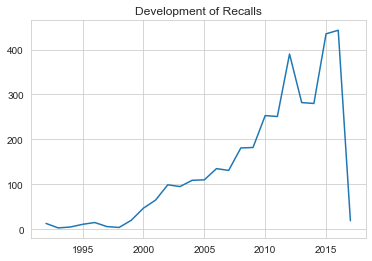

In [20]:
plt.plot(df_recall.groupby(['Launch Year']).count()['Recalls Number'])
plt.title('Development of Recalls');

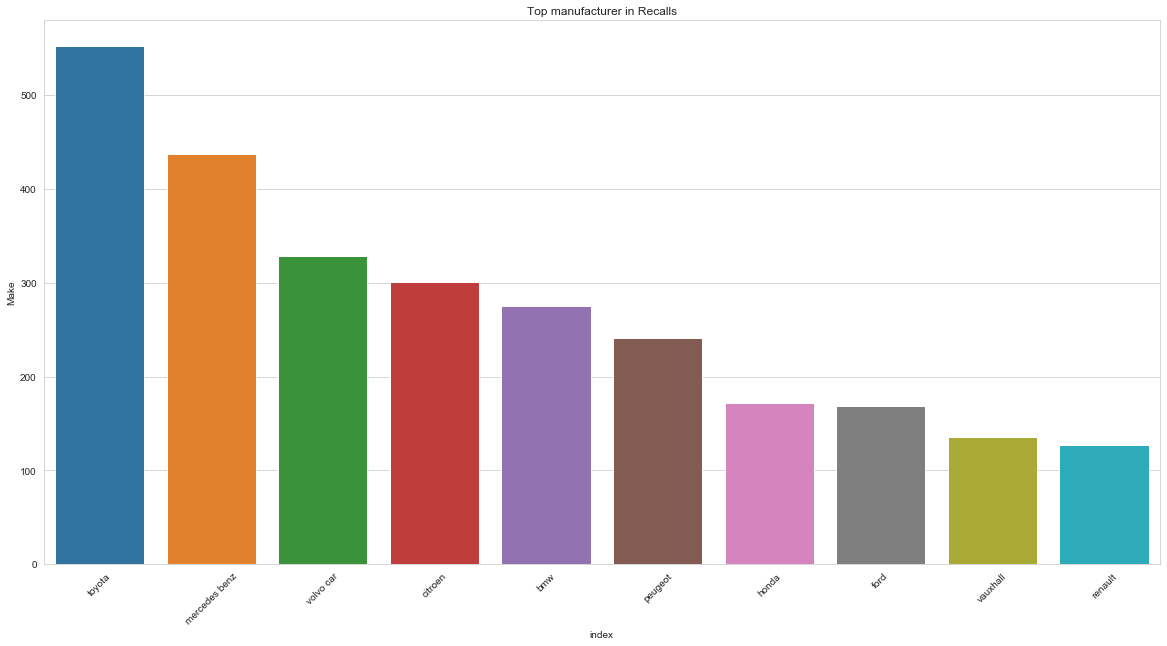

In [21]:
plt.figure(figsize=(20,10))
sns.barplot(x = 'index', y = 'Make', data = df_recall['Make'].value_counts()[:10].reset_index())
plt.xticks(rotation=45)
plt.title('Top manufacturer in Recalls');

### Correlation Analysis

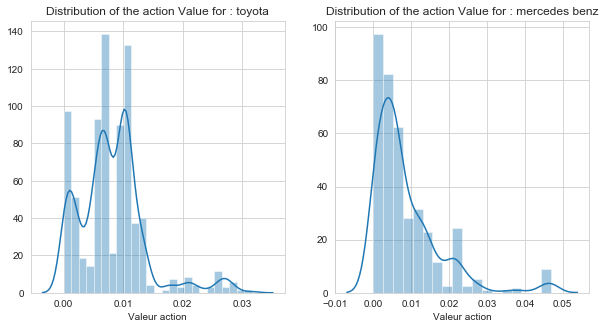

In [22]:
def plot_valeur_marque(df, y, marque):
    '''
    The following function aims to compute the development of the Action value for a certain constructer.
    
    ---
    Attributes:
        df : The first dataframe containing the different columns
        y : The labels
        marque : The constructer for which we want to plot.
        
    '''
    df['Valeur action'] = y
    sns.distplot(df[df['Make'] == marque]['Valeur action'])
    plt.title("Distribution of the action Value for : {}" .format(marque))
    
plt.figure(figsize=(10,5))
plt.subplot(121)
plot_valeur_marque(df_recall, y_array, 'toyota')
plt.subplot(122)
plot_valeur_marque(df_recall, y_array, 'mercedes benz')

We can see that the distribution of the Action value differs from a constructer to another. Mainly, that should be taken in consideration when constructing our model.

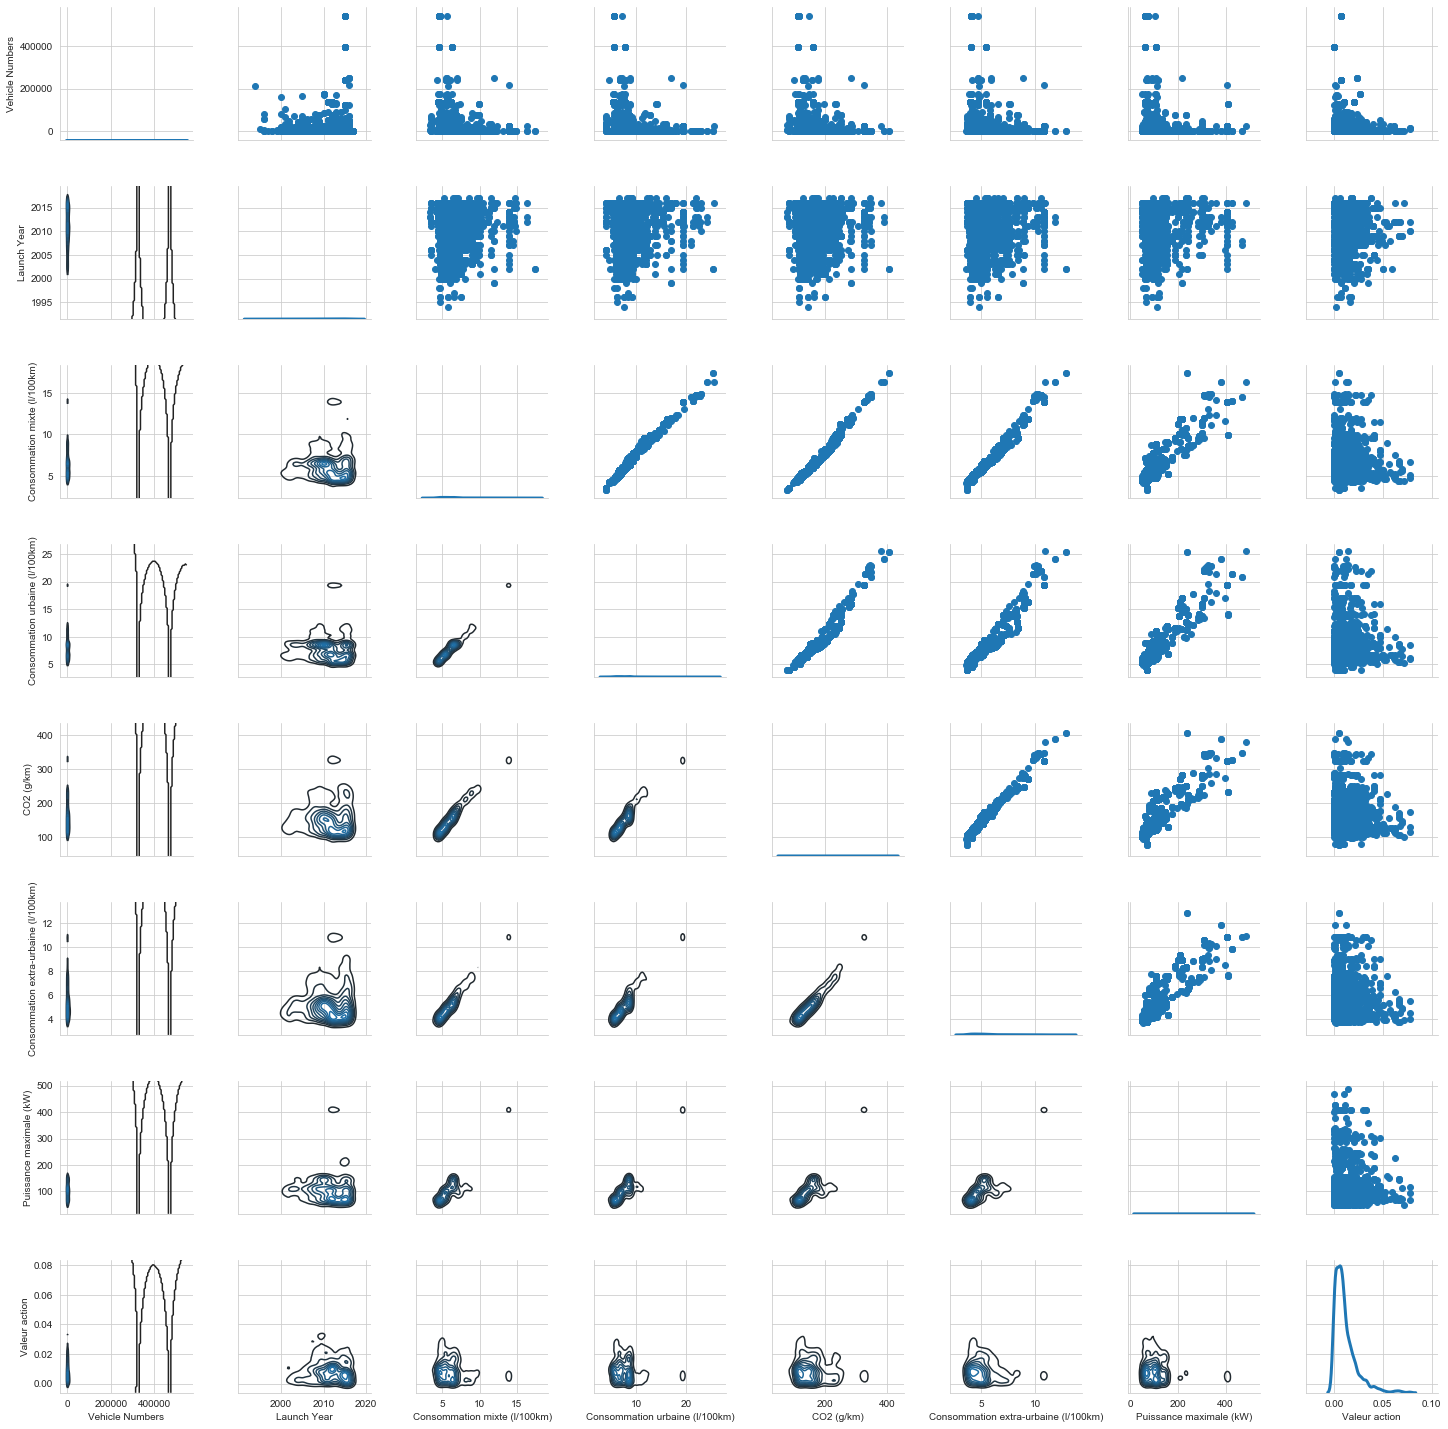

In [23]:
def plot_Pair_plot(df, y):
    '''
        The following function aims to plot a grid containing a scatter plot between each two numerical variable and
        the diagonal will be a distribution plot of the varibale.
        
        ---
        Attributes:
            df : The dataframe containing our attributes and variables.
            y : The array containing the values to be predicted
            
        
    '''
    df['Valeur action'] = y
    g = sns.PairGrid(df[list(df.corr().columns)].dropna())

    g.map_upper(plt.scatter)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=3, legend=False);

plot_Pair_plot(df_recall, y_array)

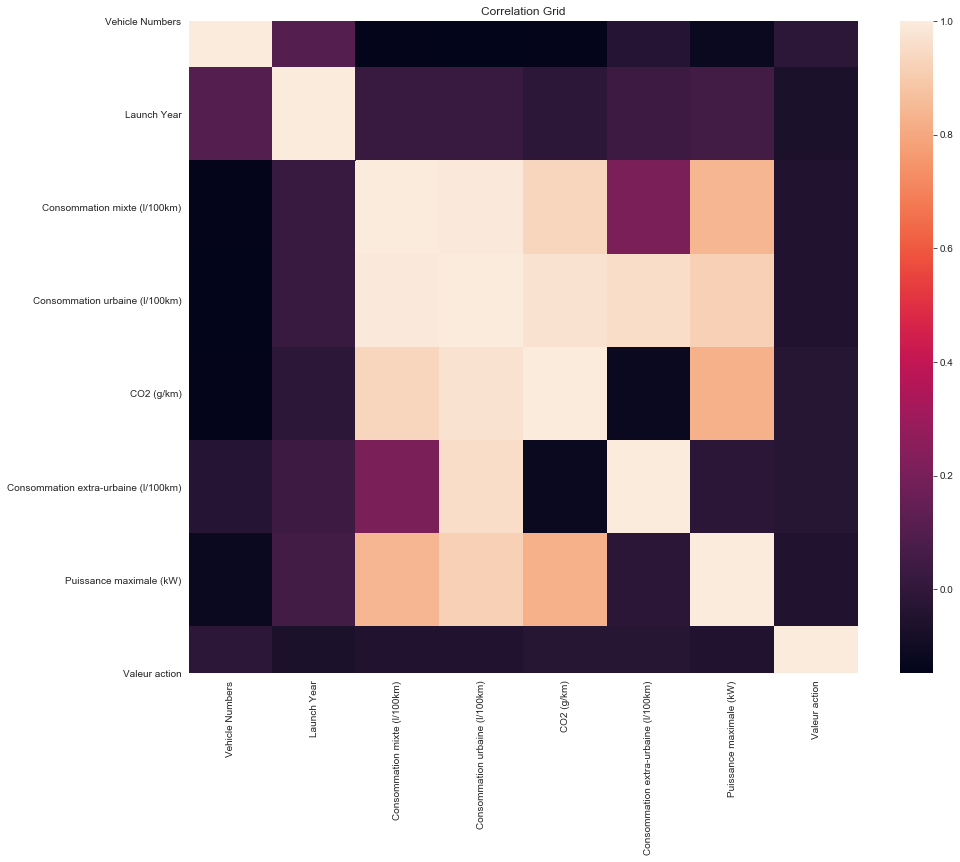

In [24]:
def plot_correlations(df, y):
    '''
    The following function aims to compute the correlation between different numerical attributes of our dataframe
    
    --- 
    Attributes:
        df : Our dataframe containing attributes
        y : The array containing our values to be predicted
    
    '''
    
    df['Valeur action'] = y
    plt.figure(figsize = (15,12))
    sns.heatmap(df_recall.corr())
    plt.title('Correlation Grid')
    plt.show()
    
plot_correlations(df_recall, y_array)

We can see that a certain correlation can be observed between our different variables, and therefore could be used in our model. <br>

Now let's try to see if the columns that contains some text explications and descriptifs are relevant to our case and could be used in our model. We will be using a Cloud of Words and a plot that highlights the relevant and communly used words.

In [25]:
def plot_words(df, name_column):   
    '''
        The following function aims to plot a wordcloud of the words present in a column of our dataframe.
        
        ---
        Attributes:
            df: Our dataframe.
            name_colum: The columns that we want to analyse.
    '''
    # First, let's take all the tokens that are present in our column and tokenize them using nltk
    tokens_defect = []
    for i in range(len(df)):
        try :
            tokens_defect.extend(df[name_column][i].split(' '))
        except:
            pass

    tokens_defect = [elements for elements in tokens_defect if len(elements) > 0] # Keep the relevent words
    tokens_defect = [word_tokenize(element)[0] for element in tokens_defect] # Tokenize
    tokens_defect = [elements for elements in tokens_defect if type(elements) is str] ## Only keep Str instances

    # We will be using the stopwords present in the wordcloud library and we will add some other irrelevent words
    stopwords = set(STOPWORDS)
    stopwords.update(["may", "possible", "worst", "extreme"])

    # Let's create our plot
    text = ' '.join(tokens_defect)
    wordcloud = WordCloud(stopwords=stopwords).generate(text)
    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('WordCloud of the Column : {}' .format(name_column))
    plt.show()

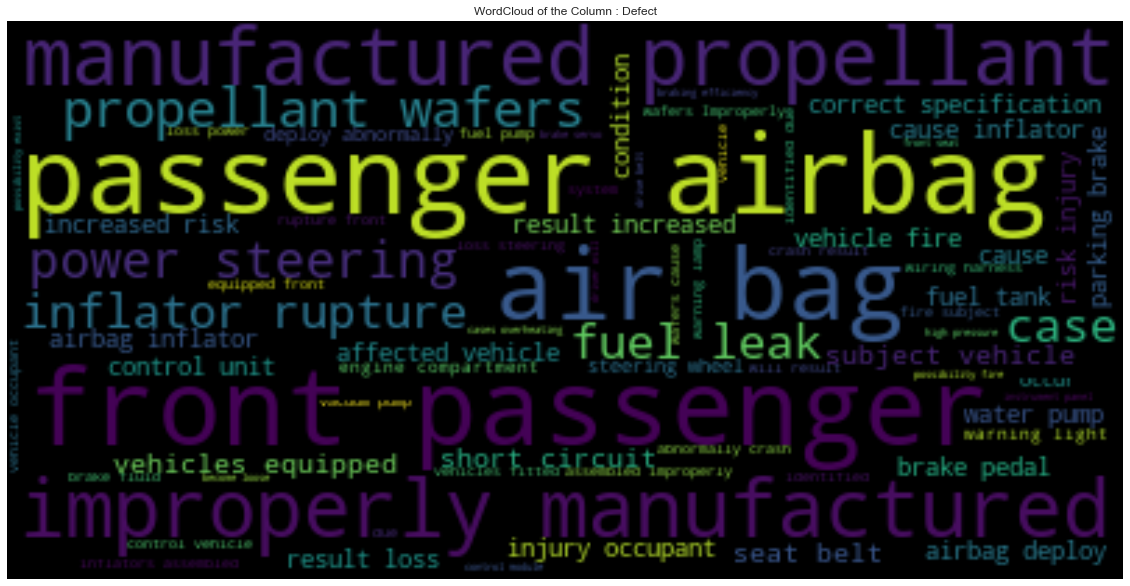

In [26]:
plot_words(df_recall, 'Defect')

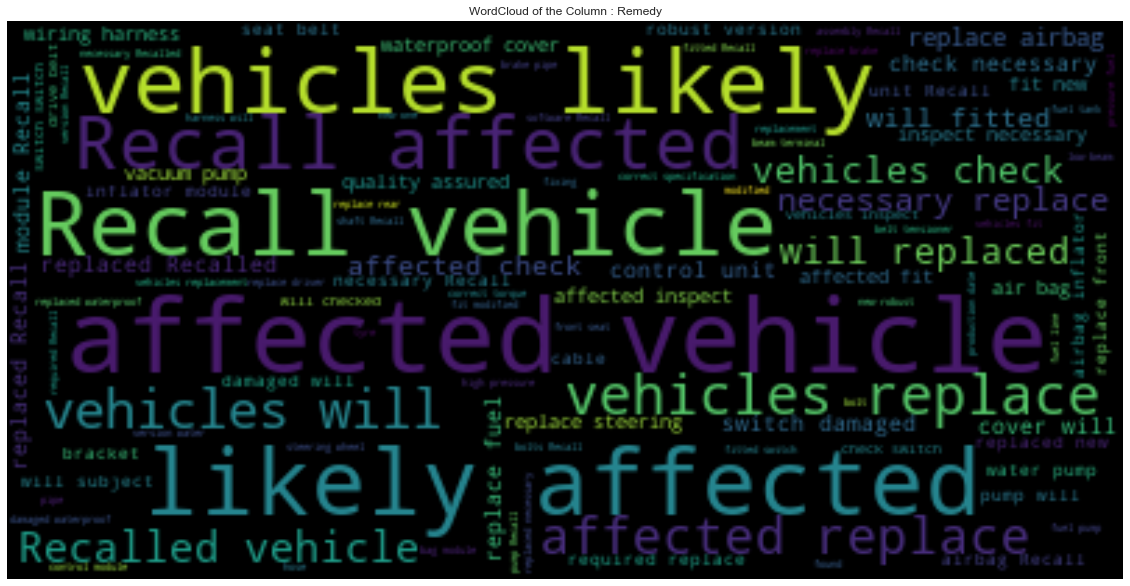

In [27]:
plot_words(df_recall, 'Remedy')

In [28]:
def plot_nlp_graph(data,Brand,column):
    
    '''
        The following functions aims to create an interactive plot to analyse the different words that are present
        in a certain column.
        
        ---
        Attributes : 
            data : our dataframe containing the column from which we want to extract our words
            Brand : The brand in which we are interested
            column : The column containing the words and which we want to analyse.
    
    '''
    
    df = data
    brand  = Brand
    col = column
    nlp = en_core_web_sm.load()
    df_copy = df.copy()
    df_copy['column_parsed'] = df_copy[col].apply(nlp)
    corpus = st.CorpusFromParsedDocuments(df_copy,category_col = 'Make', parsed_col= 'column_parsed').build()
    html = produce_scattertext_explorer(corpus, category=brand, category_name=brand,not_category_name='Other_Brands', width_in_pixels=1000,minimum_term_frequency=5, transform=st.Scalers.scale)
    file_name = 'Conventions2012ScattertextScale.html'
    open(file_name, 'wb').write(html.encode('utf-8'))
    IFrame(src=file_name, width = 1200, height=700)
    return IFrame(src=file_name, width = 900, height=700)

In [29]:
plot_nlp_graph(df_recall, Brand='kia', column='Concern')

### Final pre-processing pipeline
**This simple pipeline imputes the numerical variables with their respective medians and drops all non-numerical variables.**

In [30]:
numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median'))
])

num_cols = ['Consommation mixte (l/100km)', 
            'Consommation urbaine (l/100km)', 
            'CO2 (g/km)', 
            'Consommation extra-urbaine (l/100km)',
            'Puissance maximale (kW)', 'Launch Year', 'Vehicle Numbers']

drop_cols = df_recall.columns.difference(num_cols)

preprocessor_comp = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('drop cols', 'drop', drop_cols),
    ])

In [31]:
# make sure it works
preprocessor_comp.fit_transform(df_recall)

array([[6.12687501e+00, 7.80119053e+00, 1.48888889e+02, ...,
        1.04668129e+02, 1.99200000e+03, 6.84100000e+04],
       [6.12687501e+00, 7.80119053e+00, 1.48888889e+02, ...,
        1.04668129e+02, 1.99200000e+03, 6.84100000e+04],
       [6.12687501e+00, 7.80119053e+00, 1.48888889e+02, ...,
        1.04668129e+02, 1.99200000e+03, 3.00700000e+03],
       ...,
       [6.12687501e+00, 7.80119053e+00, 1.48888889e+02, ...,
        1.04668129e+02, 2.01700000e+03, 6.10000000e+02],
       [5.27047899e+00, 6.60475633e+00, 1.27017121e+02, ...,
        9.52388877e+01, 2.01700000e+03, 6.10000000e+02],
       [6.12687501e+00, 7.80119053e+00, 1.48888889e+02, ...,
        1.04668129e+02, 2.01700000e+03, 5.00000000e+01]])

### Scoring metric :
The score is based on a business metric that we call: exponential mean squared error


$$
    exp\_loss =
	\begin{aligned}
\frac{1}{n} \sum_{i=1}^n exp{\left[(y_{true} - y_{pred})^2\right]} \enspace 
	\end{aligned}
$$


Score interpretation:
* The lower the score the better.
* The motivation behind using the exponential terms lies in the small order of magnitude that the values live in.

In [51]:
from sklearn.metrics import make_scorer

def loss(y_true, y_pred):
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    exp_loss = np.mean(np.exp((y_true - y_pred) ** 2))
    return exp_loss
    
asp_loss = make_scorer(loss, greater_is_better=False)

In [52]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=5)

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit

clf = Pipeline(steps=[
    ('preprocessing', preprocessor_comp),
    ('classifier', regressor)])

step = 4  # to limit the running time we divide sample size by step
scores_Xdf = -cross_val_score(clf, df_recall[::step], y_array[::step],
                              cv=5, scoring=asp_loss, n_jobs=2)

print("mean: %e (+/- %e)" % (scores_Xdf.mean(), scores_Xdf.std()))

mean: 1.001292e+00 (+/- 2.243943e-03)


The final classes:

In [43]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df.copy()
        
        non_numerical = list(['A6', 'A 6', 'V .', 'M 0', 'A5', 'N 0', 'M 5', 'V 0', 'D 5', 'M', 'N 1',
                     'V 1', 'M 7', 'S 6', 'A 7', 'A 1', '5', 'M 1', 'D 7', 'A 0', 'M 6', 'A 3',
                     'N', 'A 5', 'A 8', 'D 6', '6', 'A 4', 'M5', 'M6', 'A4', 'A 9'])
        map_dict = {'VOLKSWAGEN': 'VW',
                'VOLVO': 'VOLVO CAR', # 'VOLVO BUS', 'VOLVO TRUCK'
                'MG': 'MG MOTOR',     # 'MG ROVER'
                'CHEVROLET': 'CHEVROLET UK', # 'CHEVROLET USA'
                'LEXUS': 'TOYOTA',
                'QUATTRO': 'AUDI',
                'MERCEDES AMG': 'MERCEDES BENZ', # 'MERCEDES BENZ CARS UK LTD', 'MERCEDES BENZ VANS UK LTD', 'MERCEDES BENZ BUS', 'MERCEDES BENZ TRUCKS UK LTD'
                'LTI VEHICLES': 'LTI',
                'DANGEL': 'DANGEL',
                'THE LONDON TAXI COMPANY': 'LTI',
                'RENAULT TECH': 'RENAULT', # 'RENAULT TRUCKS UK LTD', 'RENAULTTRUCKS UK LTD', 'RENAULT VI', 'RENAULT AGRICULTURE'
                'JAGUAR LAND ROVER LIMITED': 'JAGUAR',
                'MERCEDES': 'MERCEDES BENZ', # 'MERCEDES BENZ CARS UK LTD', 'MERCEDES BENZ VANS UK LTD', 'MERCEDES BENZ BUS', 'MERCEDES BENZ TRUCKS UK LTD'
                'BMW I': 'BMW', # 'BMW MOTORCYCLES', 'BMW MOTORRAD'
                'FORD CNG TECHNIK': 'FORD',
               }
        
        
        
        
        df_co2 = pd.read_csv('data/'+'data_co2.csv', low_memory=False)
        df_groupe_marque = pd.read_excel('data/'+'voiture_groupe_marque.xlsx')
        
        df_co2['Marque'] = df_co2['Marque'].apply(lambda x : x.strip())
        df_co2['Marque'] = df_co2['Marque'].apply(lambda x : x.replace('-', ' '))

        for col in ['Consommation mixte (l/100km)', 'Consommation urbaine (l/100km)', 'Puissance maximale (kW)']:
            df_co2[col] = df_co2[col].apply(
                lambda x: str(x).replace(',','.')).astype(float)

        for col in ['Consommation extra-urbaine (l/100km)', 'Boîte de vitesse']:
            df_co2[col] = df_co2[col].apply(
                lambda x: str(x).replace(',','.'))
            df_co2[col] = df_co2[col].apply(
                lambda x: str(x).strip())
        
        for index, row in tqdm(df_co2[~(df_co2['Boîte de vitesse'].isin(non_numerical))].iterrows()):
            switch_value = row['Boîte de vitesse']
            df_co2.loc[index,'Boîte de vitesse'] = row['Consommation extra-urbaine (l/100km)']
            df_co2.loc[index,'Consommation extra-urbaine (l/100km)'] = switch_value
        
        df_co2 = df_co2[~df_co2['Consommation extra-urbaine (l/100km)'].isin(non_numerical)]
        df_co2['Consommation extra-urbaine (l/100km)'] = df_co2['Consommation extra-urbaine (l/100km)'].astype(float)
        df_co2.drop(['Unnamed: 0', 'CNIT'], axis=1, inplace=True)
        
        
        
        df_co2.Marque = df_co2.Marque.replace(map_dict)
        df_co2.Marque = df_co2.Marque.str.lower()

        marque_found = []
        marque_not_found = []
        for a in df_co2.Marque.unique():
            if a in X_encoded.Make.unique():
                marque_found.append(a)
            else:
                marque_not_found.append(a)
        
        modele_found = []
        modele_not_found = []

        for a in df_co2['Modèle dossier'].unique():
            if a in X_encoded.Model.unique():
                modele_found.append(a)
            else:
                modele_not_found.append(a)
        df_co2_num = df_co2.groupby(['Marque','Modèle dossier', 'Annee']).mean().reset_index()

        df_co2_non_num = df_co2.groupby(['Marque','Modèle dossier', 'Annee'])['Boîte de vitesse'
                                                                        ].agg(pd.Series.mode).reset_index()
        df_co2 = df_co2_num.merge(df_co2_non_num, on=['Marque','Modèle dossier', 'Annee'])
        
        
        
        X_encoded['Make'] = X_encoded['Make'].apply(lambda x : x.strip())
        X_encoded['Make'] = X_encoded['Make'].apply(lambda x : x.replace('-', ' '))
        df_groupe_marque['Marques'] = df_groupe_marque['Marques'].str.upper()

        X_encoded['Launch Date']= pd.to_datetime(X_encoded['Launch Date'])
        X_encoded['Launch Year']= X_encoded['Launch Date'].dt.year

        X_encoded['Build Start']= pd.to_datetime(X_encoded['Build Start'], errors= 'coerce')
        X_encoded['Build End']= pd.to_datetime(X_encoded['Build End'], errors= 'coerce')

        X_encoded.Model = X_encoded.Model.fillna(value=X_encoded['Recalls Model Information'])
        
        print(int(len(X_encoded[X_encoded.Make.isin(marque_found)])*100/len(X_encoded)),
              '% de données de recall restantes après merge sur marque avec CO2')
        print(int(len(X_encoded[X_encoded.Model.isin(modele_found)])*100/len(X_encoded)),
             '% de données de recall restantes après merge sur modèle avec CO2')
        print(int(len(X_encoded[X_encoded.Make.isin(marque_found)][X_encoded.Model.isin(modele_found)])*100/len(X_encoded)),
              '% de données de recall restantes après merge sur marque et modèle avec CO2')
        
        
        condition = (X_encoded.Make.isin(marque_found)) & (X_encoded.Model.isin(modele_found))
        num_cols = ['Consommation mixte (l/100km)', 'Consommation urbaine (l/100km)', 'CO2 (g/km)',
                    'Consommation extra-urbaine (l/100km)', 'Puissance maximale (kW)']

        for col in num_cols:
            X_encoded[col] = float("NaN")

        for index, row in tqdm(X_encoded[condition].iterrows()):
            make = row['Make']
            model = row['Model']
            year = row['Launch Year']
            condition_match = (df_co2['Marque'] == make) & (df_co2['Modèle dossier'] == model)
            after_index = []
            before_index = []
            for index_2, row_2 in df_co2[condition_match].iterrows():
                if row_2['Annee'] >= year:
                    after_index.append(index_2)
                elif row_2['Annee'] < year:
                    before_index.append(index_2)
            if after_index:
                X_encoded.loc[index, num_cols] = df_co2.loc[after_index, num_cols].mean()
            elif before_index:
                X_encoded.loc[index, num_cols] = df_co2.loc[before_index, num_cols].mean()
        
        keep_cols = num_cols + ['Launch Year', 'Vehicle Numbers']
        
        X_encoded = X_encoded[keep_cols]
        
        numeric_transformer = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median'))
        ])

        preprocessor_comp = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, keep_cols),
            ])
        
        X_array = preprocessor_comp.fit_transform(X_encoded)
        
        
        return X_array

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(
            n_estimators=20, max_depth=50)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test - `ramp_test_submission`. 

First, ensure that `ramp-worflow` is installed (see the [github repo](https://github.com/paris-saclay-cds/ramp-workflow) for installation instructions). 

Now you can use `ramp_test_submission`. This command will test on files in [`submissions/starting_kit`](/submissions/starting_kit) by default. To specify testing on a different folder use the flag `--submission`. For example to run the test on `submissions/solution1` use: `ramp_test_submission --submission solution1`.

If it runs and print training and test errors on each fold, then you can submit the code.

For example, below we test the starting kit:

In [61]:
!ramp_test_submission --quick-test

Testing Prediction of autoindustry stock fluctuation from product recalls
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
6599it [05:47, 19.01it/s]
95 % de données de recall restantes après merge sur marque avec CO2
58 % de données de recall restantes après merge sur modèle avec CO2
55 % de données de recall restantes après merge sur marque et modèle avec CO2
1976it [00:20, 98.63it/s] 
95 % de données de recall restantes après merge sur marque avec CO2
58 % de données de recall restantes après merge sur modèle avec CO2
55 % de données de recall restantes après merge sur marque et modèle avec CO2
1976it [00:18, 109.46it/s]
95 % de données de recall restantes après merge sur marque avec CO2
42 % de données de recall restantes après merge sur modèle avec CO2
41 % de données de recall restantes après merge sur marque et modèle avec CO2
635it [00:05, 119.41it/s]
	score  asp loss        time
	train      1.01  383.216387
	valid      